# Search agent

In [1]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

[Skip to main content](https://www.nyc.gov/mayors-office/mayors-bio#mainContent) *   [Services](https://www.nyc.gov/main/services) *   [View all services](https://www.nyc.gov/main/services) *   [Events](https://www.nyc.gov/main/events) *   [Office of the Mayor](https://www.nyc.gov/mayors-office) *   [Your government](https://www.nyc.gov/main/your-government) *   [Understanding local government](https://www.nyc.gov/main/your-government) *   [nyc.gov home](https://www.nyc.gov/main) [NYC](https://www.nyc.gov/) [NYC](https://www.nyc.gov/) [Office of the Mayor](https://www.nyc.gov/mayors-office) *   [News](https://www.nyc.gov/mayors-office/news) *   [Contact the Mayor](https://www.nyc.gov/mayors-office/contact-the-mayor) *   [Biography](https://www.nyc.gov/mayors-office/mayors-bio) [Contact the Mayor](https://www.nyc.gov/mayors-office/contact-the-mayor) ![Image 2](https://www.nyc.gov/adobe/dynamicmedia/deliver/dm-aid--052e534c-1b88-4f18-835e-49b66126c154/mayors-bio-crop-jpg.webp?preferwebp=

In [2]:
from langgraph.prebuilt import create_react_agent
from langchain_deepseek import ChatDeepSeek

model = ChatDeepSeek(model = 'deepseek-chat')
research_agent = create_react_agent(
    model= model,
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [3]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [4]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_00_D1EYLVI883navghX437OTsTm)
 Call ID: call_00_D1EYLVI883navghX437OTsTm
  Args:
    query: current mayor of New York City NYC
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City NYC", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Mayor_of_New_York_City", "title": "Mayor of New York City - Wikipedia", "content": "The current mayor is Eric Adams, who was elected on November 2, 2021, and took office shortly after midnight on January 1, 2022.", "score": 0.92857105, "raw_content": null}, {"url": "https://www.instagram.com/nycmayor/?hl=en", "title": "Mayor Eric Adams (@nycmayor) · New York, NY - Instagram", "content": "1M follow

# math agent

In [5]:
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(model = 'deepseek-chat')

def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [6]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_00_NbUYYwP5b5wFwo5CiCYhJzyl)
 Call ID: call_00_NbUYYwP5b5wFwo5CiCYhJzyl
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_00_6Dmn9O3JN0HmvDuXATeIEGe8)
 Call ID: call_00_6Dmn9O3JN0HmvDuXATeIEGe8
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56.0




In [7]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
llm = ChatDeepSeek(model = 'deepseek-chat')

supervisor = create_supervisor(
    model=llm,
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

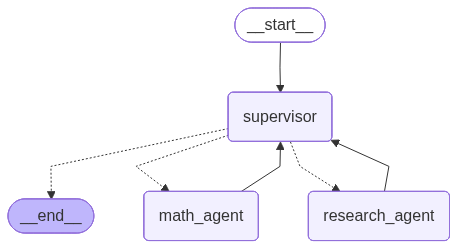

In [8]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [9]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Based on the research findings:

**US GDP in 2024:** $29.2 trillion (nominal GDP)

**New York State GDP:** Approximately $1.78-1.9 trillion (sources indicate $1.78 trillion as a baseline, with growth to around $1.8-1.9 trillion range for 2024)

**Percentage Calculation:**
- Using $1.78 trillion: New York represents about 6.1% of US GDP
- Using $1.9 trillion: New York represents about 6.5% of US GDP

New York consistently ranks as the 3rd largest state economy in the US (after C